In [1]:
from iminuit import Minuit, describe, Struct

# Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import time
import ROOT
import pandas as pd
from root_pandas import read_root
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'xtick.labelsize': 16}) 
mpl.rcParams.update({'ytick.labelsize': 16}) 

Welcome to JupyROOT 6.09/01


# Defines how to get dataframe from ROOT TTree

In [4]:
def getData(inputFiles):
    cols = ['cluster_pt','cluster_eta','cluster_phi','cluster_e_cross','cluster_e','cluster_ncell','cluster_iso_tpc_04','cluster_iso_its_04','cluster_NN1','cluster_NN2','cluster_Lambda']
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print 'Processed', inputFilename, 'in',  end-start, 'seconds'
    return pd.concat([x for x in dataframes])

# Gets dataframes from dataset(s)

In [5]:
# NTuples found in /project/projectdirs/alice/NTuples
#mcFiles = ["16c3b_small.root"]
mcFiles = ["16c3c_pthat3_small.root"]#["16c3b_small.root"]
dataFiles = ["13d_small.root"]#,"13def_small.root",'13e_small.root']
mcHists = getData(mcFiles)
dataHists = getData(dataFiles)

Processed 16c3c_pthat3_small.root in 27.7159700394 seconds
Processed 13d_small.root in 24.135643959 seconds


# Define cuts

In [6]:
def applyCuts(data):
    data.eval('ecrossOvere = cluster_e_cross/cluster_e', inplace=True)
    print 'Before cuts' , data.shape
    data = data.query('cluster_pt>8.0')
    print 'Ater pt > 8 GeV cut ' , data.shape
    data = data.query('ecrossOvere>0.03')
    print 'After ecross/e > 0.03 cut' , data.shape
    data = data.query('cluster_NN2<1.0 and cluster_NN2>0')
    print 'After NN2 within (0.1) ', data.shape
    data = data.query('cluster_NN1<1.0 and cluster_NN1>0')
    print 'After NN2 within (0.1)', data.shape
    data = data.query('cluster_iso_tpc_04<100')
    print 'After iso < 100 cut ', data.shape
    data = data.query('cluster_ncell>2')
    print 'After ncell > 2 cut ', data.shape
    data = data.query('cluster_Lambda<2.0')
    print 'After lambda < 2.0 ' , data.shape
    return data

# Apply cuts

In [8]:
dataHists = applyCuts(dataHists)
mcHists = applyCuts(mcHists)

Before cuts (244833, 13)
Ater pt > 8 GeV cut  (244833, 13)
After ecross/e > 0.03 cut (244833, 13)
After NN2 within (0.1)  (244833, 13)
After NN2 within (0.1) (244833, 13)
After iso < 100 cut  (244833, 13)
After ncell > 2 cut  (244833, 13)
After lambda < 2.0  (244833, 13)
Before cuts (689379, 13)
Ater pt > 8 GeV cut  (689379, 13)
After ecross/e > 0.03 cut (689379, 13)
After NN2 within (0.1)  (689379, 13)
After NN2 within (0.1) (689379, 13)
After iso < 100 cut  (689379, 13)
After ncell > 2 cut  (689379, 13)
After lambda < 2.0  (689379, 13)


In [9]:

def plotcorr(histo,label,figname):
    nbins = 100
    y = histo['cluster_NN1']
    x = histo['cluster_Lambda']
    nullfmt = NullFormatter()         # no labels
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.04
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    fig = plt.figure(1, figsize=(8, 8))
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    axHistx.xaxis.set_major_formatter(nullfmt) #no labels
    axHisty.yaxis.set_major_formatter(nullfmt)
    hb = axScatter.hexbin(x, y, cmap='viridis') #gridsize=60
    #axScatter.plot((0, 1), (0.27, 0.27), 'r-',linestyle=':')
    #axScatter.plot((0.85, 0.85), (0, 1.0), 'r-',linestyle=':')
    plt.text(0.72, 0.90,label, horizontalalignment='center',  verticalalignment='center', transform=axScatter.transAxes, bbox=dict(facecolor='white', alpha=0.75))
    binwidth = 0.25
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth
    axScatter.set_xlim((0.0, 1.0))
    axScatter.set_ylim((0.0, 1.0))
    axScatter.set_xlabel('NN output')
    axScatter.set_ylabel('Lambda')
    yhist, xhist, patches = axHistx.hist(x,nbins, range=(0, 1.0)) #here it gets the NN histogram
    xhist= np.delete(xhist,-1)
    xhist = np.add( xhist, (xhist[1]-xhist[0])/2.0 )
    yerrhist = np.sqrt(yhist)
    xerrhist = np.full(len(yerrhist), (xhist[1]-xhist[0])/2.0)
   
    axHisty.hist(y,nbins, range=(0.0,1.0), orientation='horizontal')
    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())
    plt.show()
    fig.savefig('../JupyterPNGOutput/'+figname+'.png', dpi=fig.dpi)
    return yhist, xhist, yerrhist, xerrhist
    

In [10]:
def cutptrange(data, ptmin, ptmax):
    full = data
    iso = data.query('cluster_iso_tpc_04<2')
    noniso = data.query('cluster_iso_tpc_04>5')
    full = full.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    iso = iso.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    noniso = noniso.query('cluster_pt>%f and cluster_pt<%f' %(ptmin,ptmax))
    
   
    
    return full, iso, noniso  

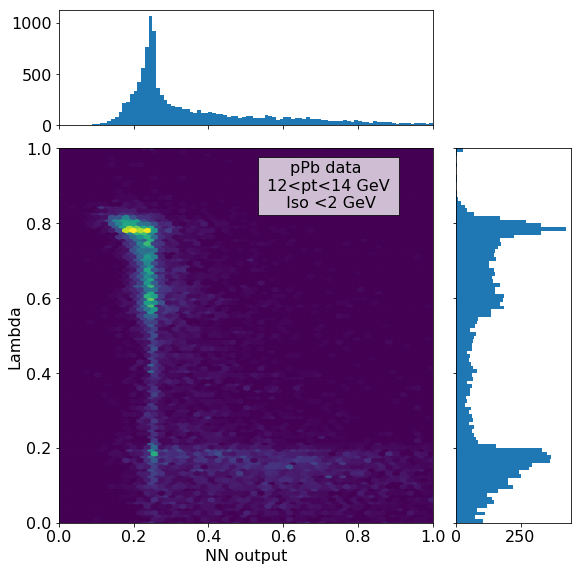

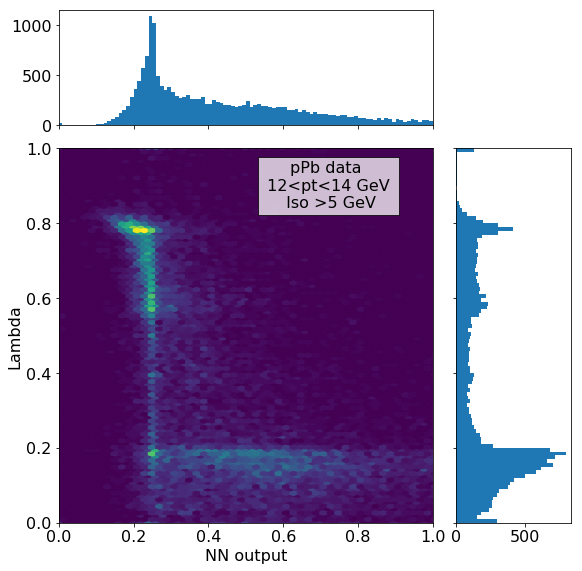

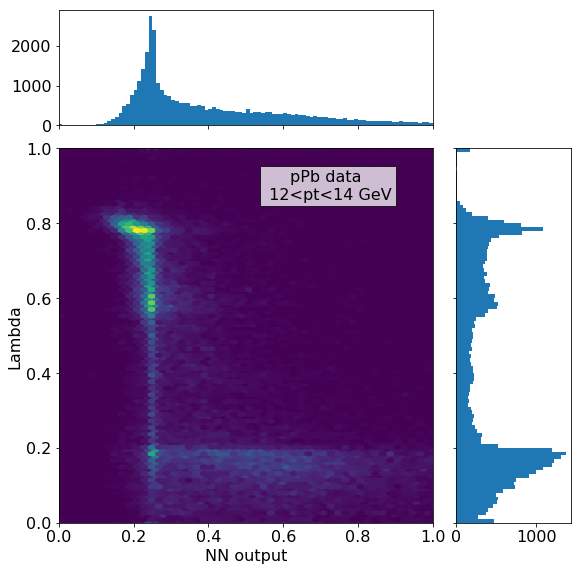

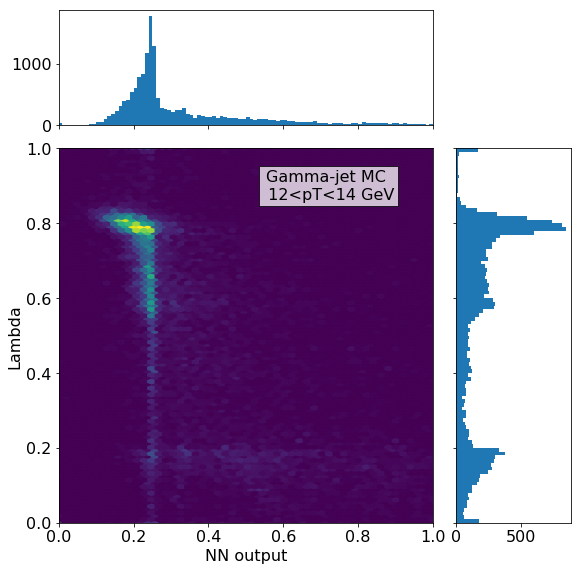

In [15]:
binedges = [12, 14]#,12.0,14.0,16.0]#,18.0,20.0,22.0,24.0,26.0,28.0]

for ipt in range(len(binedges)-1):
    ptmin = binedges[ipt]
    ptmax = binedges[ipt+1]
    ##CUT RANGE IN DATA
    full, iso, noniso = cutptrange(dataHists, ptmin, ptmax)
    
    #iso.to_csv(r'isolatedData.txt', header=None, index=None, sep=' ', mode='a')
    header = ['cluster_pt','cluster_NN1','cluster_Lambda']
    iso.to_csv('isolatedData.csv', columns = header, index=None)
    noniso.to_csv('nonisolatedData.csv', columns = header, index=None)
    
    hiso, bins, hiso_err, hiso_xerr = plotcorr(iso,'pPb data \n %2.0f<pt<%2.0f GeV \n Iso <2 GeV' %(ptmin,ptmax),'Iso_Data%2.0f_%2.0f' %(ptmin,ptmax))
    hnoniso, bins, hnoniso_err, hnoniso_xerr = plotcorr(noniso,'pPb data \n %2.0f<pt<%2.0f GeV \n Iso >5 GeV' %(ptmin,ptmax),'Non_Data%2.0f_%2.0f' %(ptmin,ptmax))
    plotcorr(full,'pPb data \n %2.0f<pt<%2.0f GeV' %(ptmin,ptmax),'all_Data%2.0f_%2.0f' %(ptmin,ptmax))
    ##dealing with MC
    fullMC, XX, XY = cutptrange(mcHists, ptmin, ptmax)
    fullMC.to_csv('MC.csv', columns = header, index=None)
    hMC, XX, XY, XZ = plotcorr(fullMC,'Gamma-jet MC \n %2.0f<pT<%2.0f GeV' %(ptmin,ptmax),'all_MC_%2.0f_%2.0f' %(ptmin,ptmax))
    

FCN = 38522.945872 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 7.52873854298e-20 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,S,7074.42,12.7432,0,0,,,
2,B,4793.08,17.3849,0,0,,,


+,S,B
S,1.00,-0.92
B,-0.92,1.00


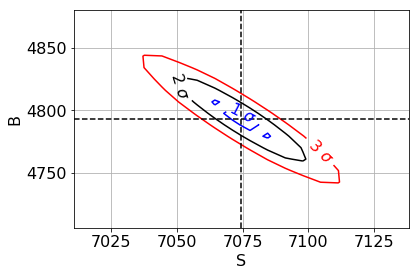

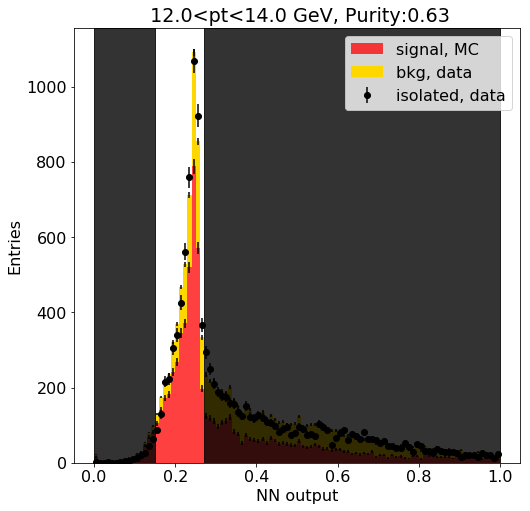

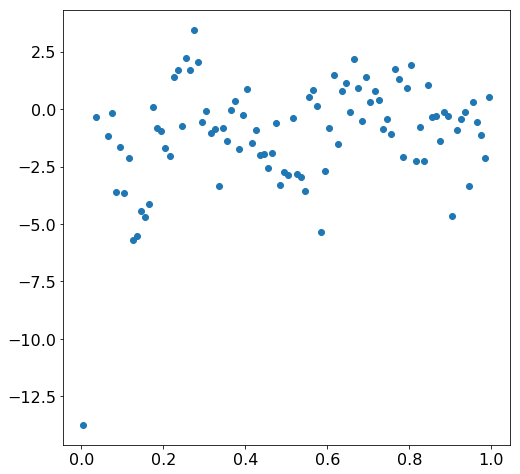

DataIso [  2.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   1.00000000e+00   6.00000000e+00
   5.00000000e+00   9.00000000e+00   1.30000000e+01   2.00000000e+01
   2.50000000e+01   4.40000000e+01   6.30000000e+01   8.60000000e+01
   1.29000000e+02   2.16000000e+02   2.23000000e+02   3.05000000e+02
   3.39000000e+02   4.26000000e+02   5.62000000e+02   7.60000000e+02
   1.06900000e+03   9.23000000e+02   3.66000000e+02   2.94000000e+02
   2.50000000e+02   2.10000000e+02   1.89000000e+02   1.77000000e+02
   1.76000000e+02   1.59000000e+02   1.57000000e+02   1.34000000e+02
   1.25000000e+02   1.51000000e+02   1.23000000e+02   1.18000000e+02
   1.27000000e+02   1.19000000e+02   1.08000000e+02   1.06000000e+02
   9.70000000e+01   8.30000000e+01   9.10000000e+01   9.60000000e+01
   7.40000000e+01   7.90000000e+01   9.60000000e+01   9.00000000e+01
   7.50000000e+01   7.60000000e+01   7.20000000e+01   1.03000000e+02
   9.60000000e+01   8.6000

/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: InitialParamWarning: errordef is not given. Default to 1.
/root/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in divide


In [15]:
import sys

print 'DataIso', hiso
print 'DataNonIso', hnoniso
print 'SignalMC', hMC
print 'bincenters', bins

y = hiso
yerr = np.sqrt(y)
bkg = hnoniso
signal = hMC
    
def Chi2(S, B):
    model = B*bkg+S*signal
    chi2 = np.power( y -model ,2.0)
    sumchi2 = np.sum(chi2[2:85]) 
    return sumchi2

signalerr = np.divide(np.sqrt(signal), np.sum(signal))
signal = np.divide(signal, np.sum(signal)) 
bkgerr = np.divide(np.sqrt(bkg), np.sum(bkg))
bkg = np.divide(bkg, np.sum(bkg)) 

init = np.sum(hiso)
m = Minuit(Chi2, S=0.5*init, B=0.5*init, error_B=1, error_S=1)
m.migrad()
m.print_matrix()
m.draw_contour('S','B', bound=5, show_sigma=True);
#print 'chi2 ',np.sum(ratio[:40])
minbin = 15
maxbin = 27
purity = np.sum(signal[minbin:maxbin])/(np.sum(bkg[minbin:maxbin])+np.sum(signal[minbin:maxbin]))
print 'Purity: ', purity
print '# of photons ', np.sum(y[minbin:maxbin])

signal = np.multiply(signal,m.values['S'])
signalerr = np.multiply(signalerr, m.values['S'])
bkg    = np.multiply(bkg,m.values['B'])
bkgerr = np.multiply(bkgerr, m.values['B'])

fig= plt.figure(3, figsize=(8, 8))
#
plt.bar(bins, signal, yerr=signalerr, width=bins[1]-bins[0], label='signal, MC',color='red',ecolor='black',alpha=0.75) 
plt.bar(bins, bkg, yerr=bkgerr, bottom=signal,  ecolor='black', color='gold', width=bins[1]-bins[0],label='bkg, data') 
plt.errorbar(bins,y, yerr=yerr, label='isolated, data',fmt='o', mfc='black',color='black')
plt.legend()
plt.xlabel('NN output')
#plt.xlabel('Lambda')
plt.ylabel('Entries')
plt.title(' %2.1f<pt<%2.1f GeV'%(ptmin,ptmax))
fig.savefig('../JupyterPNGOutput/templatefit%2.0f_%2.0f.png' %(ptmin,ptmax), dpi=fig.dpi)
ax = plt.gca()
ax.axvspan(0.0, minbin/100.0, alpha=0.80, color='black')
ax.axvspan(maxbin/100.0, 1.0, alpha=0.80, color='black')
plt.title(' %2.1f<pt<%2.1f GeV, Purity:%2.2f'%(ptmin,ptmax,purity))
fig.savefig('../JupyterPNGOutput/templatefitShaded%2.0f_%2.0f.png' %(ptmin,ptmax), dpi=fig.dpi)
plt.show()
fig = plt.figure(4, figsize=(8, 8))
total = signal + bkg
ratio = np.divide(y-total,yerr)
plt.plot(bins, ratio,'o')
plt.show()
ratio = np.power(ratio,2.0)


